# Lymphocytocis classification

__1__ in case of __tumoral__ and __0__ in case of __reactive__ cases

# 1. Read the data

### - read some samples and visualize


In [27]:
import os
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from datetime import datetime
import random
from google.colab import drive
import zipfile
from tqdm import tqdm

import torch
from torch.utils.data import random_split, DataLoader, Dataset
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import balanced_accuracy_score


In [2]:
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
with zipfile.ZipFile('/content/drive/MyDrive/dlmi/dlmi-lymphocytosis-classification.zip', 'r') as zip_ref:
  zip_ref.extractall('/content/data')

there are: 163 patients in the train set and 43 in the test set
images per patient range from 16 images for patient P62 to a max 198 images for patient P35


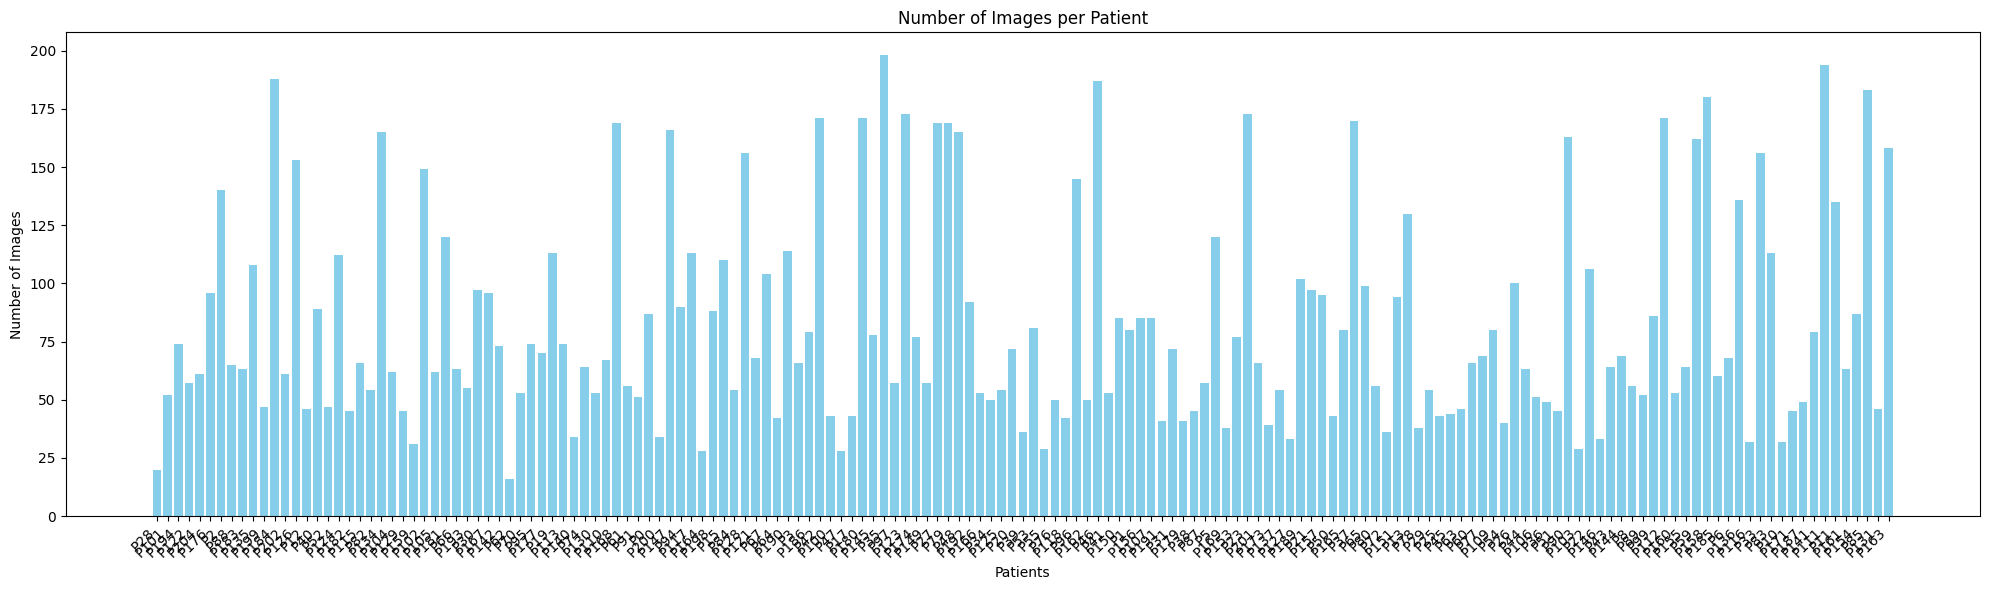

In [4]:
# read images and labels
train_dir= 'data/trainset'
test_dir= 'data/testset'

train_patients= os.listdir(train_dir)
test_patients= os.listdir(test_dir)

train_patients= [i for i in train_patients if not i.endswith('.csv')]

print(f'there are: {len(train_patients)} patients in the train set and {len(test_patients)} in the test set')

images={}
for patient in train_patients:

    num_images= len(os.listdir(os.path.join(train_dir, patient)))
    images[patient]= num_images


max_patient = max(images, key=images.get)
max_images = images[max_patient]
min_patient = min(images, key=images.get)
min_images = images[min_patient]

print(f'images per patient range from {min_images} images for patient {min_patient} to a max {max_images} images for patient {max_patient}')

# Create bar plot
plt.figure(figsize=(20, 6))
plt.bar(images.keys(), images.values(), color='skyblue')
plt.xlabel('Patients')
plt.ylabel('Number of Images')
plt.title('Number of Images per Patient')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

there is a clear imbalance between how the images are distributed per patiens, next step is to analyse if ther is any class imbalance

do proper data analysis

In [5]:
train_true = pd.read_csv(os.path.join(train_dir, 'trainset_true.csv'))
train_true.head

<bound method NDFrame.head of        ID  LABEL GENDER         DOB  LYMPH_COUNT
0     P26      1      M   11/3/1933        11.20
1    P183      1      M   5/15/1942        12.80
2     P89      1      M   6/19/1935         9.60
3    P123      1      M   1/27/1931       122.60
4     P61      1      F    3/5/1931        11.60
..    ...    ...    ...         ...          ...
158  P135      1      M  27-08-1951         9.45
159    P8      0      M  16-05-1975         4.91
160  P130      0      F  16-05-1943         4.17
161   P70      1      M  05-09-1987         5.66
162   P60      0      F   5/23/1993         6.42

[163 rows x 5 columns]>

In [6]:
def extract_year_and_compute_age(dob_str):
    parts = dob_str.replace('-', '/').split('/')
    year_str = parts[-1]
    year = int(year_str)
    current_year = datetime.now().year
    age = current_year - year
    return age

Basic Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 163 entries, 0 to 162
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   ID           163 non-null    object 
 1   LABEL        163 non-null    int64  
 2   GENDER       163 non-null    object 
 3   DOB          163 non-null    object 
 4   LYMPH_COUNT  163 non-null    float64
 5   AGE          163 non-null    int64  
dtypes: float64(1), int64(2), object(3)
memory usage: 7.8+ KB
None


Class Distribution:
1    113
0     50
Name: LABEL, dtype: int64




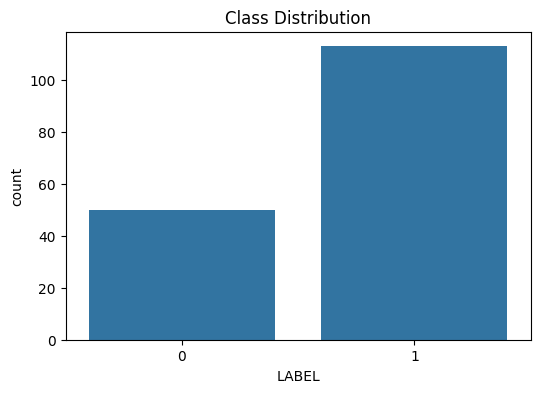

Distribution of GENDER:
M    82
F    80
f     1
Name: GENDER, dtype: int64


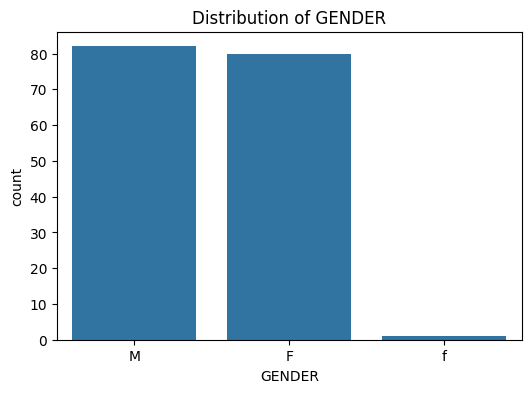

Summary Statistics of LYMPH_COUNT:
count    163.000000
mean      26.423926
std       46.784365
min        2.280000
25%        5.045000
50%        7.810000
75%       20.445000
max      295.000000
Name: LYMPH_COUNT, dtype: float64


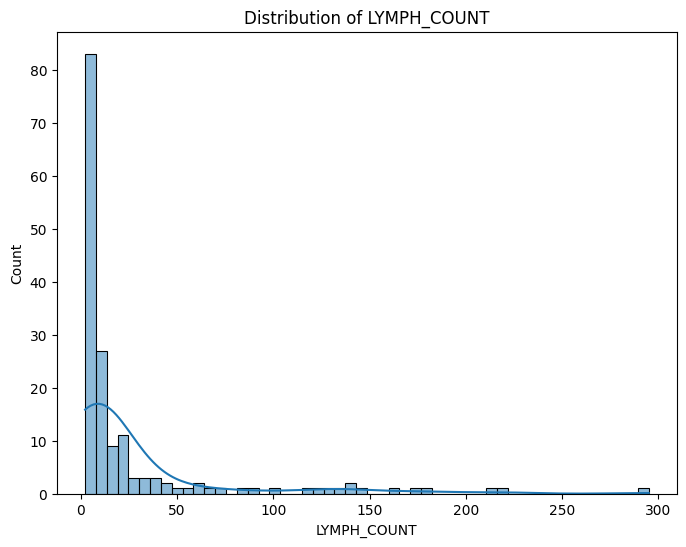

Summary Statistics of Age:
count    163.000000
mean      72.760736
std       17.664862
min       26.000000
25%       64.000000
50%       76.000000
75%       87.500000
max      103.000000
Name: AGE, dtype: float64


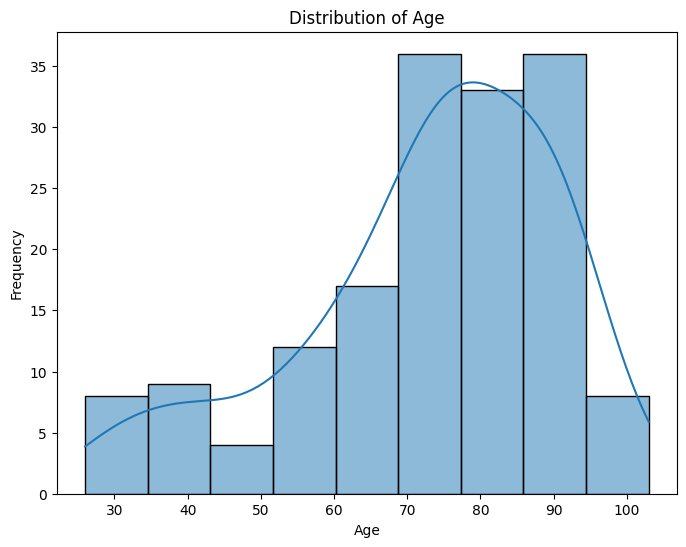

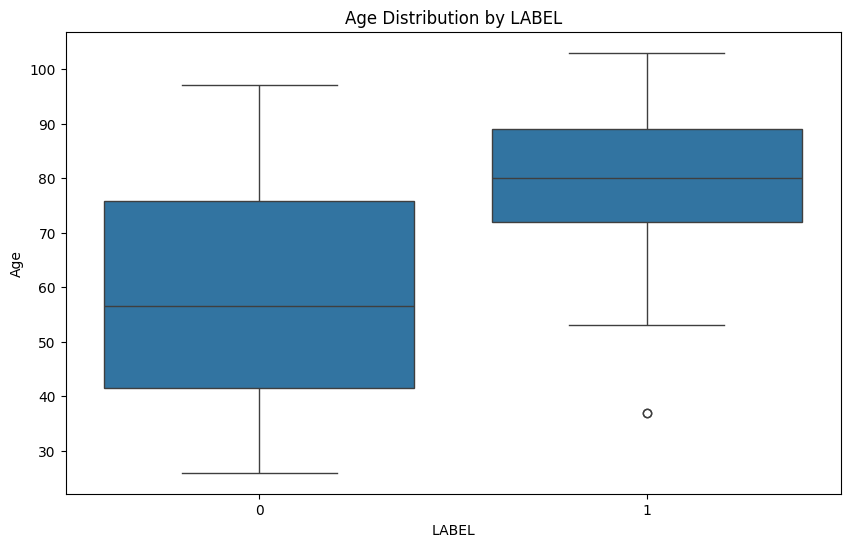

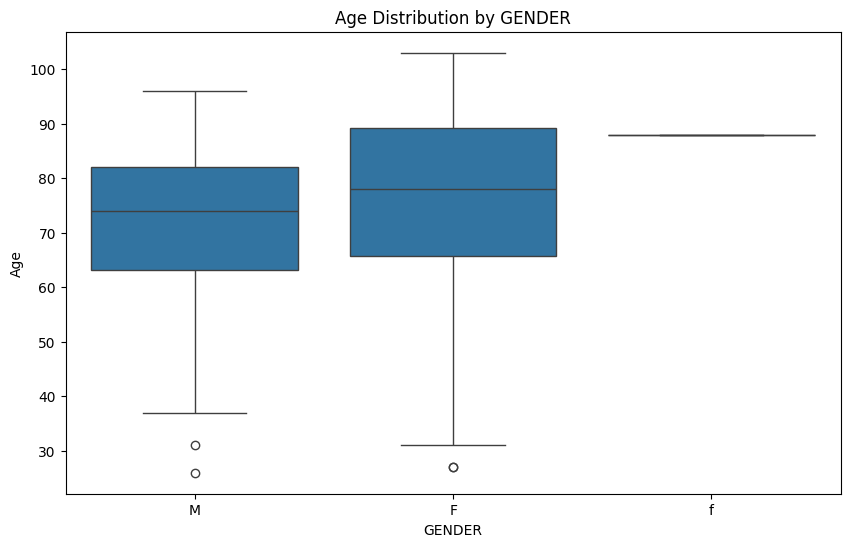

In [7]:
# Load the labels data
train_true = pd.read_csv(os.path.join(train_dir, 'trainset_true.csv'))



#compute the age of each patient
# Calculate age of each patient

train_true['AGE'] = train_true['DOB'].apply(extract_year_and_compute_age)


#Basic information
print("Basic Information:")
print(train_true.info())
print("\n")

#Class distribution
class_distribution = train_true['LABEL'].value_counts()
print("Class Distribution:")
print(class_distribution)
print("\n")
plt.figure(figsize=(6, 4))
sns.countplot(x='LABEL', data=train_true)
plt.title("Class Distribution")
plt.show()

#Explore categorical variables
print("Distribution of GENDER:")
print(train_true['GENDER'].value_counts())
plt.figure(figsize=(6, 4))
sns.countplot(x='GENDER', data=train_true)
plt.title("Distribution of GENDER")
plt.show()

#Explore numerical variables
print("Summary Statistics of LYMPH_COUNT:")
print(train_true['LYMPH_COUNT'].describe())
plt.figure(figsize=(8, 6))
sns.histplot(train_true['LYMPH_COUNT'], kde=True)
plt.title("Distribution of LYMPH_COUNT")
plt.show()


##explore age info

print("Summary Statistics of Age:")
print(train_true['AGE'].describe())
plt.figure(figsize=(8, 6))
sns.histplot(train_true['AGE'], kde=True)
plt.title("Distribution of Age")
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.show()

#Explore relationships between age and other variables
plt.figure(figsize=(10, 6))
sns.boxplot(x='LABEL', y='AGE', data=train_true)
plt.title("Age Distribution by LABEL")
plt.xlabel("LABEL")
plt.ylabel("Age")
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(x='GENDER', y='AGE', data=train_true)
plt.title("Age Distribution by GENDER")
plt.xlabel("GENDER")
plt.ylabel("Age")
plt.show()


In [8]:
# Assuming 'train_true' DataFrame already contains the 'Age' column
max_age_row_index = train_true['AGE'].idxmax()
corresponding_patient_id = train_true.loc[max_age_row_index, 'ID']

# Filter the DataFrame to get all rows corresponding to the patient with the maximum age
max_age_patient_rows = train_true[train_true['ID'] == corresponding_patient_id]

print("Rows corresponding to the patient with the maximum age:")
print(max_age_patient_rows)


Rows corresponding to the patient with the maximum age:
       ID  LABEL GENDER        DOB  LYMPH_COUNT  AGE
116  P102      1      F  1/27/1921         58.7  103


there is a big class imabalance .. see how to face this later

Sampled patient IDs for class 1: ['P181', 'P113', 'P150']
Sampled patient IDs for class 2: ['P87', 'P78', 'P155']
Patient ID: P181, Class: 1 and has 120 images
Patient ID: P113, Class: 1 and has 74 images
Patient ID: P150, Class: 1 and has 85 images
Patient ID: P87, Class: 0 and has 57 images
Patient ID: P78, Class: 0 and has 38 images
Patient ID: P155, Class: 0 and has 64 images


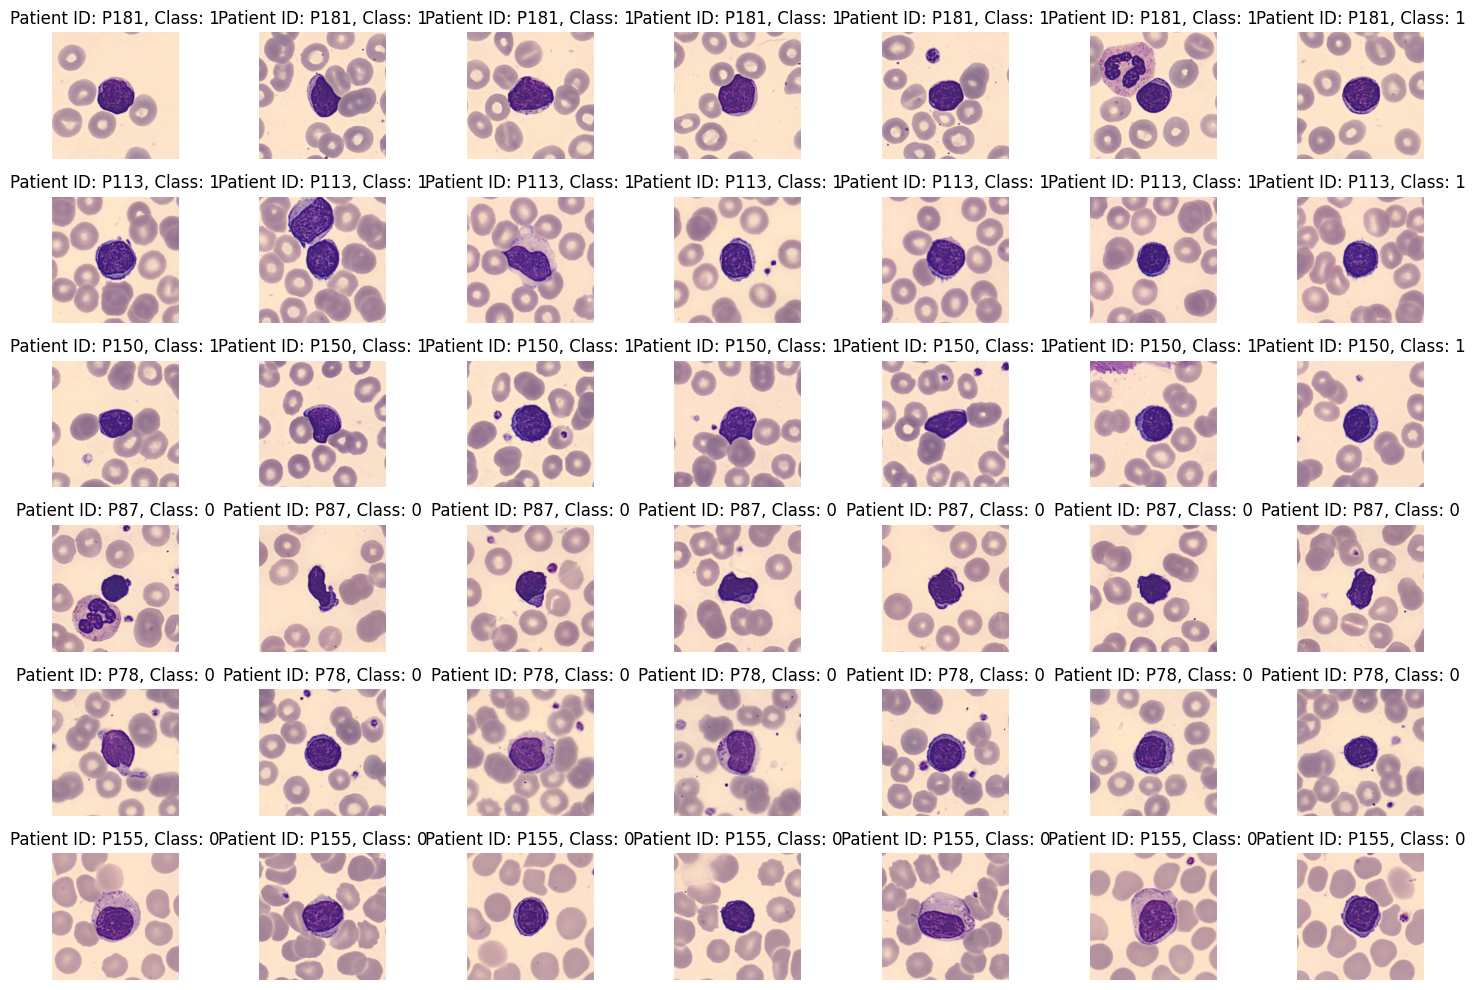

In [9]:
class_1_ids = train_true[train_true['LABEL'] == 1]['ID'].tolist()
class_1_sample = random.sample(class_1_ids, 3)
class_2_ids = train_true[train_true['LABEL'] == 0]['ID'].tolist()
class_2_sample = random.sample(class_2_ids, 3)

print("Sampled patient IDs for class 1:", class_1_sample)
print("Sampled patient IDs for class 2:", class_2_sample)

fig, axs = plt.subplots(len(class_1_sample + class_2_sample), 7, figsize=(15, 10))

# Iterate through each patient folder
for i, patient_id in enumerate(class_1_sample + class_2_sample):  # Loop through sampled patient IDs
    patient_folder = os.path.join(train_dir, patient_id)
    if not os.path.exists(patient_folder):
        print('not found (bizarre)!!!')
        continue

    # Display patient ID and class
    patient_class = train_true[train_true['ID'] == patient_id]['LABEL'].values[0]
    print(f"Patient ID: {patient_id}, Class: {patient_class} and has {len( os.listdir(patient_folder))} images")

    # Iterate through images in the patient folder
    # Iterate through the first 7 images in the patient folder
    for j, image_file in enumerate(os.listdir(patient_folder)[10:17]):
        image_path = os.path.join(patient_folder, image_file)

        # Load and display the image
        image = Image.open(image_path).convert('RGB')
        axs[i, j].imshow(image)
        axs[i, j].set_title(f"Patient ID: {patient_id}, Class: {patient_class}")
        axs[i, j].axis('off')

# Hide the empty subplots
for ax_row in axs:
    for ax in ax_row:
        ax.axis('off')

# Adjust layout and display the subplot
plt.tight_layout()
plt.show()



In [10]:
print( 'the size of the images is :',image.size)
torch.tensor((np.array(image)/255.0).transpose((2,0,1))).shape
type(image)

the size of the images is : (224, 224)


PIL.Image.Image

In [11]:
(np.array(image)/255.0).shape

(224, 224, 3)

### - create teh dataset class

In [12]:
def extract_year_and_compute_age(dob_str):
    # Splitting the string to extract the year part
    parts = dob_str.replace('-', '/').split('/')
    year_str = parts[-1]
    year = int(year_str)
    current_year = datetime.now().year
    age = current_year - year
    return age


class MyDataset(Dataset):
    def __init__(self, data_dir, transform=None, Train=True):
        labels_file= 'trainset_true.csv' if Train else 'testset_data.csv'
        self.labels = pd.read_csv(os.path.join(data_dir, labels_file))
        self.data_dir = data_dir
        self.transform = transform

        self.labels['GENDER'] = self.labels['GENDER'].str.lower().map({'m': 0, 'f': 1})
        self.labels['AGE'] = self.labels['DOB'].apply(extract_year_and_compute_age)

        self.image_info = []
        for _, row in self.labels.iterrows():
            patient_id = row['ID']
            label = row['LABEL']
            gender = row['GENDER']
            age = row['AGE']
            lymphocyte_count = row['LYMPH_COUNT']
            for img_file in os.listdir(os.path.join(self.data_dir, patient_id)):
                img_path = os.path.join(self.data_dir, patient_id, img_file)
                self.image_info.append((img_path, label, age, lymphocyte_count, gender, patient_id))

    def __len__(self):
        return len(self.image_info)

    def __getitem__(self, idx):
        # order: ID  LABEL GENDER         DOB  LYMPH_COUNT  AGE
        img_path, label, age, lymphocyte_count, gender, patient_id = self.image_info[idx]

        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)

        label = torch.tensor(label, dtype=torch.long)
        gender= torch.tensor(gender, dtype= torch.long)
        age = torch.tensor(age, dtype=torch.float)
        lymphocyte_count = torch.tensor(lymphocyte_count, dtype=torch.float)

        return image, label, age, lymphocyte_count, gender, patient_id


In [13]:

transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])


dataset = MyDataset(data_dir=train_dir, transform=transform, Train=True)


print("Length of the dataset:", len(dataset))


patient_images, label, age, lymphocyte_count, gender , patient_id= dataset[160]  # Change index to access different samples
print("Number of images for the patient:", len(patient_images))
print("Label:", label)
print("Age:", age)
print("gender: ", gender)
print("Lymphocyte count:", lymphocyte_count)


Length of the dataset: 13453
Number of images for the patient: 3
Label: tensor(1)
Age: tensor(82.)
gender:  tensor(0)
Lymphocyte count: tensor(12.8000)


### - laod the data


In [51]:
dataset= MyDataset(data_dir=train_dir, transform=transform, Train=True)
test_set= MyDataset(data_dir=test_dir, transform=transform, Train=False)

# Split dataset into train and validation sets
total_size = len(dataset)
train_size = int(0.8 * total_size)
val_size = total_size - train_size
train_set, val_set = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_set, batch_size=64, shuffle=True, drop_last=True)
val_loader = DataLoader(val_set, batch_size=64, shuffle=False, drop_last=True)
test_loader= DataLoader(test_set, batch_size=64, shuffle=False)

# 2. train baseline model

In [15]:
class MyCNN(nn.Module):
    def __init__(self, num_additional_features=3):
        super(MyCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1) #at this point 64*32*32

        self.pool = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(65536 + num_additional_features, 512)
        self.fc2 = nn.Linear(512, 1)

    def forward(self, images, additional_features):

        x = self.pool(F.relu(self.conv1(images)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))

        x = torch.flatten(x, 1)
        x = torch.cat((x, additional_features), dim=1)

        x = F.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))

        return x


In [16]:
model= MyCNN()
for data in train_loader:
    image, label, age, lymphocyte_count, gender, patient_id= data
    print(image.shape)
    additional_features = torch.stack((age, lymphocyte_count, gender), dim=1)
    print(additional_features.shape)
    out= model (image, additional_features)
    print(out.shape)
    break

torch.Size([64, 3, 256, 256])
torch.Size([64, 3])
torch.Size([64, 1])


In [42]:
device= 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'using: {device}')
save_path = '/content/drive/MyDrive/dlmi/checkpoints/model_checkpoint.pth'

model = MyCNN().to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10

using: cuda


In [47]:
checkpoint = torch.load('/content/drive/MyDrive/dlmi/checkpoints/model_checkpoint.pth' )

model.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

<All keys matched successfully>

In [48]:

best_val_bal_acc = 0.0
tr_losses = []
va_losses = []
train_bal_accs = []
val_bal_accs = []

for epoch in range(num_epochs):
    model.train()
    train_losses = []
    train_true = []
    train_preds = []

    # Training phase
    for data in tqdm(train_loader, desc='Training'):
        images, labels, age, lymphocyte_count, gender, patient_id = data
        images, labels, age, lymphocyte_count, gender = images.to(device), labels.to(device), age.to(device), lymphocyte_count.to(device), gender.to(device)
        additional_features = torch.stack((age, lymphocyte_count, gender), dim=1)

        optimizer.zero_grad()
        outputs = model(images, additional_features)
        loss = criterion(outputs.squeeze(), labels.float())
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())
        train_true.extend(labels.detach().cpu().numpy())
        train_preds.extend(outputs.detach().cpu().numpy().squeeze() > 0.5)

    # Validation phase
    model.eval()
    val_losses = []
    val_true = []
    val_preds = []
    with torch.no_grad():
        for data in tqdm(val_loader, desc='Validation'):
            images, labels, age, lymphocyte_count, gender, patient_id = data
            images, labels, age, lymphocyte_count, gender = images.to(device), labels.to(device), age.to(device), lymphocyte_count.to(device), gender.to(device)
            additional_features = torch.stack((age, lymphocyte_count, gender), dim=1)

            outputs = model(images, additional_features)
            loss = criterion(outputs.squeeze(), labels.float())

            val_losses.append(loss.item())
            val_true.extend(labels.cpu().numpy())
            val_preds.extend(outputs.cpu().numpy().squeeze() > 0.5)

    # Calculate metrics
    train_loss = np.mean(train_losses)
    val_loss = np.mean(val_losses)
    train_bal_acc = balanced_accuracy_score(train_true, train_preds)
    val_bal_acc = balanced_accuracy_score(val_true, val_preds)


    tr_losses.append(train_loss)
    va_losses.append(val_loss)
    train_bal_accs.append(train_bal_acc)
    val_bal_accs.append(val_bal_acc)

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, '
          f'Train Balanced Acc: {train_bal_acc:.4f}, Validation Balanced Acc: {val_bal_acc:.4f}')

    # Checkpoint saving
    if val_bal_acc > best_val_bal_acc:
        print(f'Validation Balanced Accuracy Improved ({best_val_bal_acc:.4f} --> {val_bal_acc:.4f}). Saving model ...')
        best_val_bal_acc = val_bal_acc
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': val_loss,
            'balanced_accuracy': val_bal_acc,
        }, save_path)


Validation: 100%|██████████| 42/42 [00:09<00:00,  4.28it/s]


Epoch 1/10, Train Loss: 0.0308, Validation Loss: 0.4268, Train Balanced Acc: 0.9814, Validation Balanced Acc: 0.8704
Validation Balanced Accuracy Improved (0.0000 --> 0.8704). Saving model ...


Validation: 100%|██████████| 42/42 [00:10<00:00,  3.93it/s]


Epoch 2/10, Train Loss: 0.0206, Validation Loss: 0.4647, Train Balanced Acc: 0.9885, Validation Balanced Acc: 0.8660


Validation: 100%|██████████| 42/42 [00:10<00:00,  3.91it/s]


Epoch 3/10, Train Loss: 0.0291, Validation Loss: 0.3858, Train Balanced Acc: 0.9820, Validation Balanced Acc: 0.8690


Validation: 100%|██████████| 42/42 [00:10<00:00,  4.09it/s]


Epoch 4/10, Train Loss: 0.0060, Validation Loss: 0.5652, Train Balanced Acc: 0.9985, Validation Balanced Acc: 0.8644


Validation: 100%|██████████| 42/42 [00:10<00:00,  3.90it/s]


Epoch 5/10, Train Loss: 0.0220, Validation Loss: 0.5405, Train Balanced Acc: 0.9849, Validation Balanced Acc: 0.8828
Validation Balanced Accuracy Improved (0.8704 --> 0.8828). Saving model ...


Validation: 100%|██████████| 42/42 [00:10<00:00,  4.03it/s]


Epoch 6/10, Train Loss: 0.0084, Validation Loss: 0.5815, Train Balanced Acc: 0.9960, Validation Balanced Acc: 0.8653


Validation: 100%|██████████| 42/42 [00:10<00:00,  3.94it/s]


Epoch 7/10, Train Loss: 0.0012, Validation Loss: 0.6170, Train Balanced Acc: 0.9999, Validation Balanced Acc: 0.8685


Validation: 100%|██████████| 42/42 [00:10<00:00,  3.90it/s]


Epoch 8/10, Train Loss: 0.0005, Validation Loss: 0.7668, Train Balanced Acc: 1.0000, Validation Balanced Acc: 0.8614


Validation: 100%|██████████| 42/42 [00:09<00:00,  4.34it/s]


Epoch 9/10, Train Loss: 0.0002, Validation Loss: 0.7525, Train Balanced Acc: 1.0000, Validation Balanced Acc: 0.8621


Validation: 100%|██████████| 42/42 [00:10<00:00,  3.83it/s]

Epoch 10/10, Train Loss: 0.0001, Validation Loss: 0.7995, Train Balanced Acc: 1.0000, Validation Balanced Acc: 0.8599


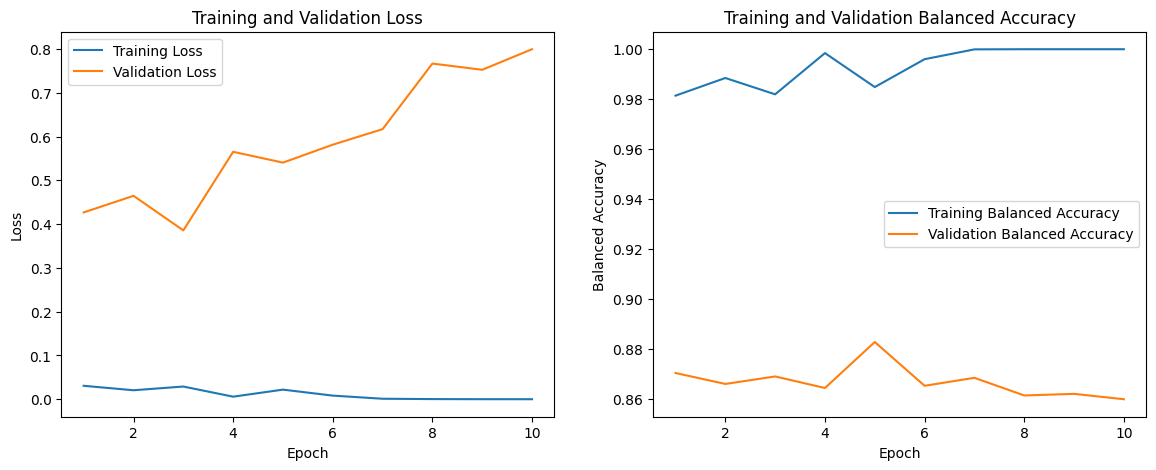

In [49]:
# Visualization of losses and accuracies
epochs_range = range(1, num_epochs + 1)
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, tr_losses, label='Training Loss')
plt.plot(epochs_range, va_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_bal_accs, label='Training Balanced Accuracy')
plt.plot(epochs_range, val_bal_accs, label='Validation Balanced Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Balanced Accuracy')
plt.title('Training and Validation Balanced Accuracy')
plt.legend()

plt.show()

In [56]:
patient_predictions = {}

with torch.no_grad():
    for data in tqdm(test_loader, desc='Testing'):
        images, _, age, lymphocyte_count, gender, patient_ids_batch = data
        images, age, lymphocyte_count, gender = images.to(device), age.to(device), lymphocyte_count.to(device), gender.to(device)

        additional_features = torch.stack((age, lymphocyte_count, gender), dim=1)
        outputs = model(images, additional_features)

        # Convert model outputs to binary predictions (0 or 1)
        predicted_labels = (outputs.squeeze() > 0.5).cpu().numpy()

        # Aggregate predictions by patient
        for pid, pred in zip(patient_ids_batch, predicted_labels):
            if pid not in patient_predictions:
                patient_predictions[pid] = []
            patient_predictions[pid].append(pred)

# Now, average the predictions for each patient and round to get the final label
final_predictions = {pid: np.round(np.mean(preds)).astype(int) for pid, preds in patient_predictions.items()}

# Convert the final predictions to a DataFrame
submission_df = pd.DataFrame(list(final_predictions.items()), columns=['ID', 'Prediction'])
submission_df.to_csv('/content/drive/MyDrive/dlmi/submission.csv', index=False)

print("Test results saved to submission.csv")

print("Test results saved to submission.csv")

Testing: 100%|██████████| 51/51 [00:15<00:00,  3.32it/s]

Test results saved to submission.csv
Test results saved to submission.csv


In [57]:
submission_df.head()

,ID,Prediction
0,P71,1
1,P16,1
2,P114,1
3,P170,1
4,P98,0


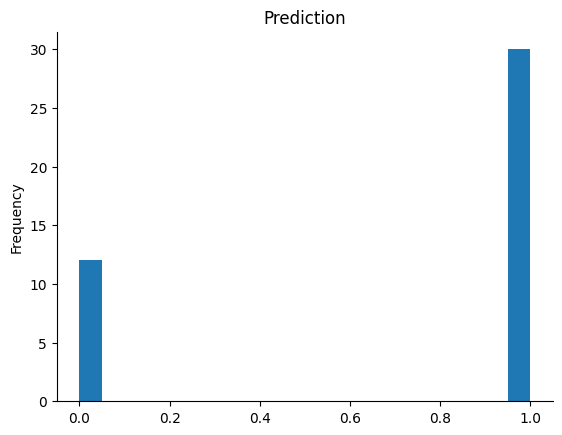

In [58]:
# @title Prediction

from matplotlib import pyplot as plt
submission_df['Prediction'].plot(kind='hist', bins=20, title='Prediction')
plt.gca().spines[['top', 'right',]].set_visible(False)

# 3. improved model